# Tutorial 1: Generating a virtual environment for the GenMR digital template


**Author:** Arnaud Mignan, Mignan Risk Analytics GmbH  
**Version:** 0.1  
**Last Updated:** 2025-10-27   
**License:** AGPL-3   

The _digital template_, first described in [Mignan (2022)](https://www.mdpi.com/1660-4601/19/23/16097) and used in the CAT Risk Modelling Sandbox [Mignan (2024)](https://github.com/amignan/Intro2CATriskModelling/blob/main/CATRiskModellingSandbox_tutorial.ipynb), is a microcosm simulation of the complex Earth system for catastrophe dynamics R&D, multi-risk prototyping in the Generic Multi-Risk (GenMR) framework, and catastrophe risk eduction. It is defined as a virtual environment populated by loss-generating events that interact with each other and with the environment. The virtual environment, to be built in this tutorial, is composed of _environmental layers_ that consist of sets of variables $\theta(x,y)$ defined in a spatial grid of coordinates $(x,y)$. Each layer may be altered by _environmental objects_ located within the layer. The parsimonious complex Earth system finally consists of a stack of interacting environmental layers defined in the natural, technological and socio-economic systems. The loss-generating events that populate the virtual environment will be defined in the next tutorial, and their occurrence rates and interactions in a third and final tutorial.

Currently, a limited number of environmental layers and objects are available (Fig. 1, Table 1). This notebook provides a concise overview of these layers using a default parameterisation, with alternative scenarios to be introduced later in the How-To Guides. The outputs generated here will serve as input for hazard and risk assessments in the subsequent tutorials.

![](../figures/digitaltemplate_env_rayshader.jpg)
<center><small><b>Fig. 1.</b> Example of the GenMR digital template (default parameterisation) showing the topography and land use layers, with water in blue, built areas in grey, and the road network in white. A soil layer is also included but not displayed. Simulation rendered using <a href='https://www.rayshader.com/' target='_blank'>Rayshader</a> (Morgan-Wall, 2022).</small></center>

<br>
<center><small><b>Tab. 1.</b> List of available environmental layers <code>EnvLayer_ID</code> (Python classes).</small></center>

| Environment | ID | Layer | Variables | Properties (examples) | Object dependencies$^*$ | References |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| Natural | `topoLayer` | Topography | Elevation $z$ | Slope, aspect | Geological & hydrological objects | Mignan (2022) |
| Natural | `soilLayer` | Soil | Depth $h$ | Factor of safety | - | Mignan (2022) |
| Natural | `natLandLayer` | Natural land | State $S$ | - | - | Mignan (2024) |
| Technological | `urbLandLayer` | Urban land | State $S$ | Exposure value, year built | Road network | Mignan (2024) |

<center><small>* Each layer additionally depends on the previous ones.</small></center>

<br>
The environmental layers are generated as follows:

* **Topography**: Represented as elevation, $z$ (m), the generic topography is defined by a west-dipping slope and a fractal dimension between 2 and 3. Environmental objects associated with peril sources modify the topography through intrusion and extrusion rules. The overall process, illustrated in Figure 2, combines methods from solid geometry and morphometry. Further details can be found in [Mignan (2022)](https://www.mdpi.com/1660-4601/19/23/16097). The main properties of the topography layer include terrain slope [$^\circ$] and aspect [$^\circ$].

![](../figures/ref_Mignan_IJERPH2022_fig2.jpg)
<center><small><b>Fig. 2.</b> Construction of the topography layer following rules of solid geometry and morphometry, illustrating the combination of geometric primitives and terrain metrics. Redrawn from <a href='https://www.mdpi.com/1660-4601/19/23/16097' target='_blank'>Mignan (2022:fig.2)</a>.</small></center>

<br>

* **Soil**: Characterised by the soil thickness, $h$ (m), which is initially spatially uniform. It can later vary through mass movement processes (using the landslide cellular automaton (CA) introduced in the next tutorial) or by a simpler rule applied here: $h = 0$ if the soil is unstable at $(x,y)$. Other soil properties remain fixed parameters at this stage. A key property of the soil layer is the factor of safety, $F_S$, which indicates whether the soil is stable, critical, or unstable.
* **Natural land**: Defined by the state $S$, with $S=-1$ for water, $S=0$ for grassland, and $S=1$ for forest. These classes represent the pre-urbanised land cover. All grid locations $(x,y)$ are considered forested except those above an elevation-dependent tree line (grassland), or below sea level ($z = 0$) and along river channels (water).
* **Urban land**: Represents the built environment, where the state $S$ overwrites the natural land classification: $S = 2$ for housing, $S = 3$ for industrial, and $S = 4$ for commercial areas. The city is generated using a hybrid model that combines the SLEUTH city growth CA (ref), a road network CA (ref), and a land-use transformation function (ref) (see [Mignan, 2024](https://www.cambridge.org/highereducation/books/introduction-to-catastrophe-risk-modelling/A3A5B5FB990921422BFEBB07734BF869#overview), for details; Fig. 3). A key property of the urban-land layer is the asset value per pixel, which serves as the exposure component in the subsequent loss assessment tutorial.

ADD Fig. 3 - from Mignan (2024)...

Sections 1 and 2 detail the simulation of the virtual natural and technological environments, respectively (v1.1.1). A future Section 3, to be released in v1.1.2, will describe the socio-economic environment of the digital template.

In [1]:
## libraries ##
import numpy as np
import pandas as pd
import copy

#import warnings 
#warnings.filterwarnings('ignore')   # commented, try to remove all warnings

from GenMR import environment as GenMR_env
from GenMR import utils as GenMR_utils

GenMR_utils.init_io()  # make folders /io and /fig if do not exist

## 1. Natural environment generation

The generic natural environment is constrained by a predominant west–east orientation, with a coastline located at `x0`. This configuration ensures that any water mass, when present, is systematically positioned on the western side of the grid (Fig. 1). By convention, rivers flow exclusively from east to west. This directional constraint simplifies the natural environment generator while still allowing it to represent a wide range of regional configurations.

### 1.1. Grid definition

All environmental layers are defined on the raster grid `RasterGrid(par)`. The default grid parameterisation `gridPar` (a dictionary) specifies an active domain of 100 × 100 km, with a reference north-south coastline fixed at `x0 = 0` (i.e., $z(x_0) = 0$). A larger computational domain, bounded by (`xmin`, `xmax`, `ymin`, `ymax`), is included to account for potential boundary effects. The active box is thus defined as (`xmin+xbuffer`, `xmax-xbuffer`, `ymin+ybuffer`, `ymax-ybuffer`). The spatial resolution is determined by the pixel width `w=0.1` km. Lower-resolution grids may be defined later for specific environmental processes. In the current version, the parameter `lat_deg` specifies the latitude at $(x = 0, y = 0)$, which is used in hurricane size modelling. A `lon_deg` parameter will be added in a future release when a longitude reference becomes necessary for additional environmental processes.

In [2]:
gridPar = {'w': .1,
           'xmin': -20, 'x0': 0, 'xmax': 120, 'ymin': -10, 'ymax': 110,
           'xbuffer': 20, 'ybuffer': 10,
           'lat_deg': 30}

grid = GenMR_env.RasterGrid(gridPar)

### 1.2. Natural peril definition (for environmental objects)

Environmental layers can be influenced by specific environmental objects; this is notably the case for the first layer to be generated, the topography. In the context of a generic and parsimonious model, only essential objects are implemented. Consequently, the environmental objects included are restricted to those associated with the perils to be modelled in later stages.

<br>
<center><small><b>Tab. 2.</b> Characteristics of peril sources that generate environmental objects affecting the topography.</small></center>

| Peril | ID | Source | Environmental object | References |
| :--- | :--- | :--- | :--- | :--- |
| Earthquake | `EQ` | Fault of coordinates (`x`,`y`), width `w_km`, dip `dig_deg`, depth `z_km` | Tectonic hill | Mignan (2022) |
| Fluvial flood | `FF` | River modelled as damped sine (`riv_A_km`, `riv_lbd`, `riv_ome`, `riv_y0`), with discharge `Q_m3/s` and implicit upstream catchment area `A_km2` | River valley | Mignan (2022) |
| Volcanic eruption | `VE` | Volcano of coordinates (`x`,`y`) | Conic volcanic edifice | Mignan (2022) |

This configuration is parameterised using the dictionary `srcPar`. In this example, two faults, one river, and one volcano are defined. Additional perils will be introduced in the next tutorial. At this stage, only perils that can modify environmental layers are included.

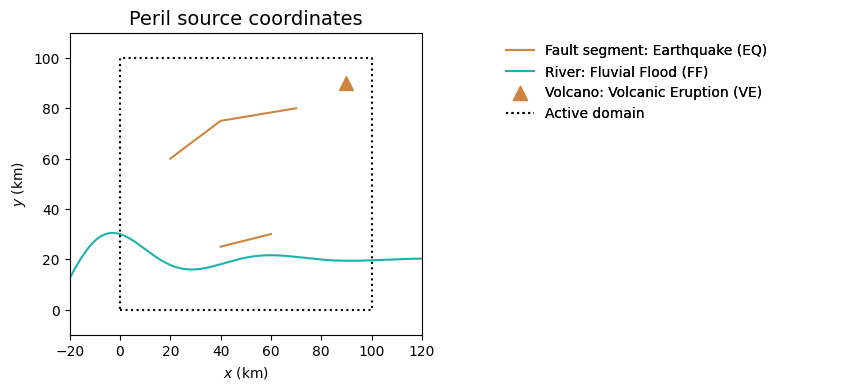

In [3]:
srcPar = {
    'perils': ['EQ', 'FF', 'VE'],
    'EQ': {'object': 'fault',
        'x': [[20, 40, 70], [40, 60]],                                        # 2 faults (2 segments, 1 segment)
        'y': [[60, 75, 80], [25, 30]],
        'w_km': [5, 5], 'dip_deg': [45, 45],
        'z_km': [2, 2], 'mec': ['R', 'R'],                                    # only reverse R mechanism for now
        'bin_km': 1},                                                         # fault spatial resolution
    'FF': {'object': 'river',
        'riv_A_km': [10], 'riv_lbd': [.03], 'riv_ome': [.1], 'riv_y0': [20],  # y = A*exp(-lbd*x)*cos(ome*x)+y0
        'Q_m3/s': [100e3], 'A_km2': 100*100},
    'VE': {'object': 'volcano', 'x': [90], 'y': [90]},
}

src = GenMR_env.Src(srcPar, grid)

GenMR_env.plot_src(src)

### 1.3. Generating the topography, soil, and land layers

Environmental layers are defined as instance of classes `EnvLayer_*` (with `*` the layer ID; see Table 1). For this version of the digital template, parsimonious natural environment models with a minimal number of input parameters are favored for illustration purposes (at the cost of some over-simplifications). A few models will be mentioned below without going into any detail. Visit the reference manual of `GenMR_Basic` for an in-depth description.

The **topography layer** (parameterized in `topoPar`) is defined with the elevation $z(x,y)$ as its main variable. It is constructed at a lower granularity with pixel width `gridPar['w'] * lores_f`. The process takes several successive steps:
* Background `bg`: Plane tilted westward with slope `bg_tan(phi)` anchored at $z = 0$ at `x0`;
* Tectonic hill(s) `th`: Ellipsoid(s) with axes constrained by the 3D fault segment geometry (with centroid adjustable along the $z$-axis by `th_Dz_km`) extruding the topography;
* Volcano(s) `vo`: Cone(s) centered on the volcano coordinates with width `vo_w_km` and height `vo_h_km` extruding the topography;
* Fractal `fr`: Fractal noise (random seed `fr_seed`) with fractal dimension `fr_Df` and overall amplitude a fraction `fr_eta` of the background topography added to the topography. Uses the Diamond-square algorithm (ref). The coastline becomes irregular around `x0` at this step;
* River valley(s) `rv`: Flat flood plain(s) tilted westward with slope `rv_tan(phiWE)` and N-S extend bound by the river exponential envelope intruding the topography (with angle `rv_tan(phiNS)` at the northern and southern boundaries). River channel(s) 2 N-S pixels wide for smooth flow and further intruded for normal channeled flow. Remnants of the original topography remain at a ratio `rv_eta`;
* Coastal strip `cs`: Coastal strip of width `cs_w_km` and slope `cs_tan(phi)` (< `bg_tan(phi)`) intruding the topography on the eastern side of the coastline. Remnants of the original topography remain at a ratio `cs_eta`.

At the end of the process, the layer is upscaled back to the default pixel width `gridPar['w']`. Except for the background topography, all other alterations are optional (`th`, `vo`, `fr`, `rv`, `cs` true or false).

The **soil layer** (parameterized in `soilPar`) is defined by two main variables, the soil thickness $h(x,y)$, initialised at constant value `h0_m`, and the water column depth $h_w(x,y)$, initialized at `wat_h_m`. In the current version, soil parameters are kept constant (effective cohesion `Ceff_Pa`, effective friction angle `phieff_deg` and soil density `rho_kg/m3`). $h(x,y)$ is then updated with the method defined in `corr` (for correction). For simplicity, locations where the factor of safety is lower than 1 get $h=0$ (method `remove_unstable`). $h_w(x,y)$ will be allowed to vary in the next tutorial (during rainstorms).

The **natural land layer** (parameterized in `natLandPar`) is defined by the state $S(x,y)$, with $S = -1$ (water) for $z(x,y)<0$ (west of coastline) and at the coordinates of the river channel(s), $S = 0$ (grassland) for $z$ greater than `ve_treeline_m`, and $S = 1$ (forest) otherwise (`ve` for vegetation). This layer can be considered a sublayer of the land use layer to be defined in Section 2, with the state updated there where urbanized.

Note that an `atmoPar` dictionary is already defined in view of a future environmental layer to describe the atmosphere (which will later include temperature and water vapor on top of pressure `pn_mbar`).

In [4]:
topoPar = {
    'lores_f': 10, 'bg_tan(phi)': 3/100,
    'th': True, 'th_Dz_km': -.5,
    'vo': True, 'vo_w_km': [9], 'vo_h_km': [1],
    'fr': True, 'fr_Df': 2.6, 'fr_eta': .5, 'fr_seed': 1,
    'rv': True, 'rv_tan(phiWE)': [1/1000], 'rv_tan(phiNS)': [1/2], 'rv_eta': .1,
    'cs': True, 'cs_w_km': 10, 'cs_tan(phi)': 1/1000, 'cs_eta': .1,
    'plt_zmin_m': -500, 'plt_zmax_m': 4500
}
soilPar = {'h0_m': 10, 'wat_h_m': 0,
           'Ceff_Pa': 20e3, 'phieff_deg': 27, 'rho_kg/m3': 2650,
           'corr': 'remove_unstable'}
natLandPar = {'ve_treeline_m': 2000}
atmoPar = {'rho_kg/m3': 1.15, 'pn_mbar': 1005}

We will build all the natural environmental layers at once. Notice that each new layer builds upon the characteristics of the previous one(s).

In [5]:
grid = GenMR_env.RasterGrid(gridPar)
topoLayer = GenMR_env.EnvLayer_topo(src, topoPar)
soilLayer = GenMR_env.EnvLayer_soil(topoLayer, soilPar)
natLandLayer = GenMR_env.EnvLayer_natLand(soilLayer, natLandPar)

/Users/arnaudmignan/Documents/GmbH_MRA/2_fundedR&D/2025-2027_GenMR_SCOR/GenMR_SCOR/GenMR/environment.py:458: RuntimeWarning: invalid value encountered in sqrt
  zth_tmp = Pe * np.sqrt(1 - (x_rot-xc_rot)**2/Le**2 - (y_rot-yc_rot)**2/We**2) +zc[seg]


We can already save the parameter sets and environmental layers (in folder `io/`) for later use:

In [6]:
GenMR_utils.save_class2pickle(src, filename = 'src')
GenMR_utils.save_class2pickle(topoLayer, filename = 'envLayer_topo')
GenMR_utils.save_class2pickle(soilLayer, filename = 'envLayer_soil')
GenMR_utils.save_class2pickle(natLandLayer, filename = 'envLayer_natLand')

### 1.4. Environmental layer properties (and attribute plotting)

Environmental layers can have built-in properties (Tab. 1). The function `plot_EnvLayers()` plots each environmental layer and its main properties (when the argument `file_ext` is filled with `jpg`, `pdf` or other formats accepted by `matplotlib.pyplot.savefig`, a file is created in the folder `figs/`):

/Users/arnaudmignan/Documents/GmbH_MRA/2_fundedR&D/2025-2027_GenMR_SCOR/GenMR_SCOR/GenMR/environment.py:603: RuntimeWarning: divide by zero encountered in divide
  FS = (par['Ceff_Pa'] / (par['rho_kg/m3'] * GenMR_utils.g_earth * h) + np.cos(slope * np.pi/180) * \


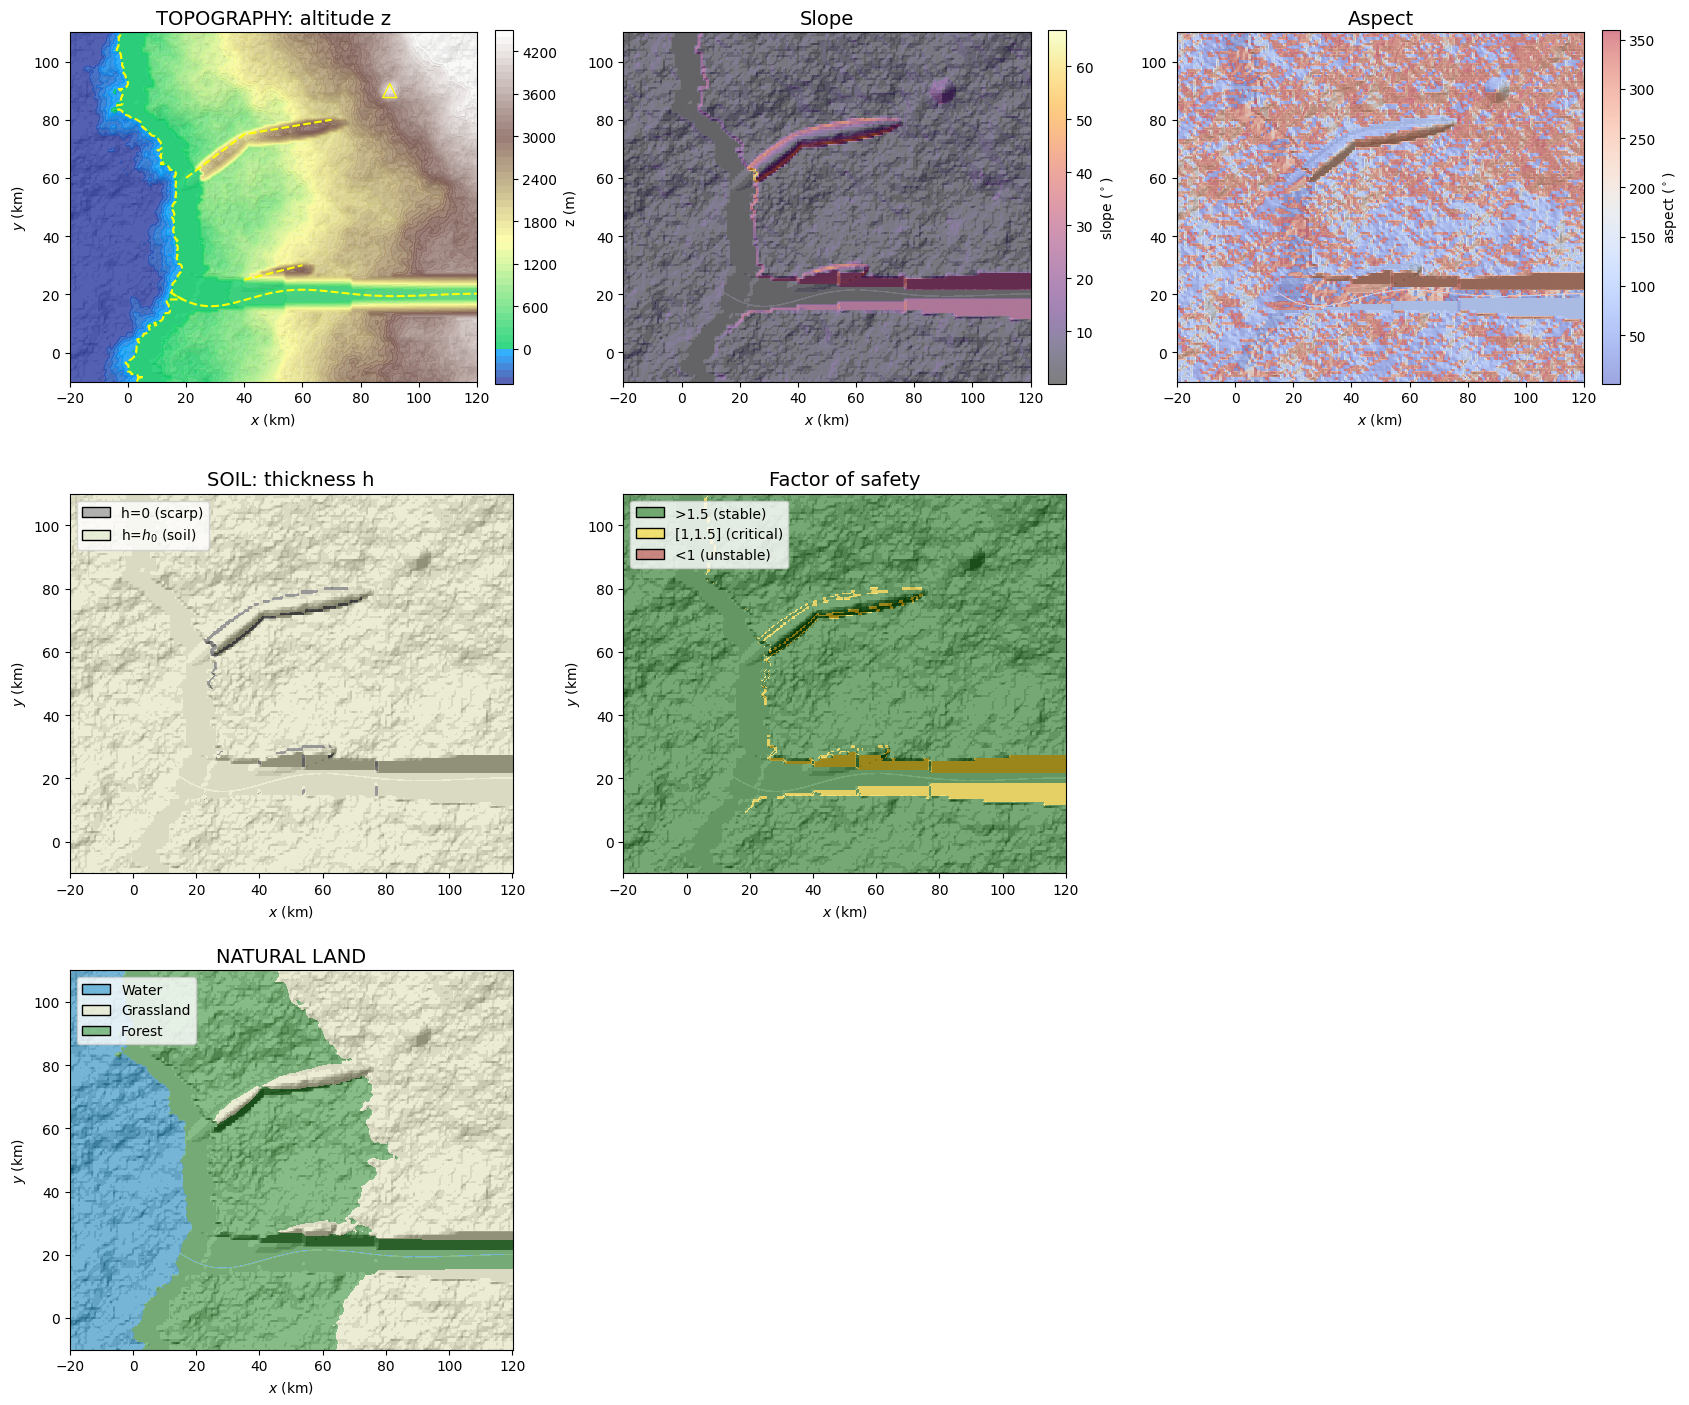

In [7]:
GenMR_env.plot_EnvLayers([topoLayer, soilLayer, natLandLayer], file_ext = 'jpg')

The function `plot_EnvLayer_attr()` plots individual attributes (incl. properties) from environmental layers. If the elevation is given in the argument `hillshading_z`, hill shading is added in the background.

/Users/arnaudmignan/Documents/GmbH_MRA/2_fundedR&D/2025-2027_GenMR_SCOR/GenMR_SCOR/GenMR/environment.py:603: RuntimeWarning: divide by zero encountered in divide
  FS = (par['Ceff_Pa'] / (par['rho_kg/m3'] * GenMR_utils.g_earth * h) + np.cos(slope * np.pi/180) * \


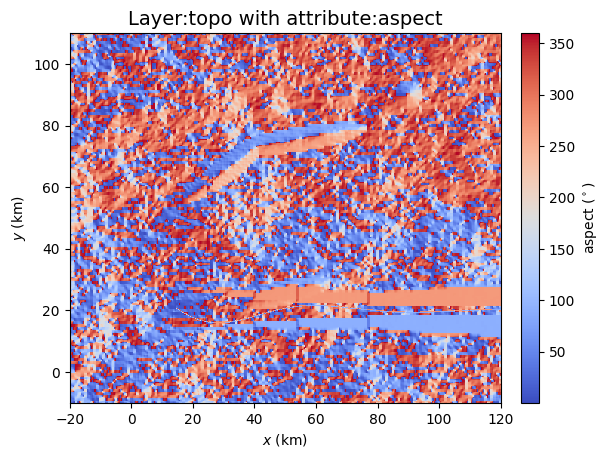

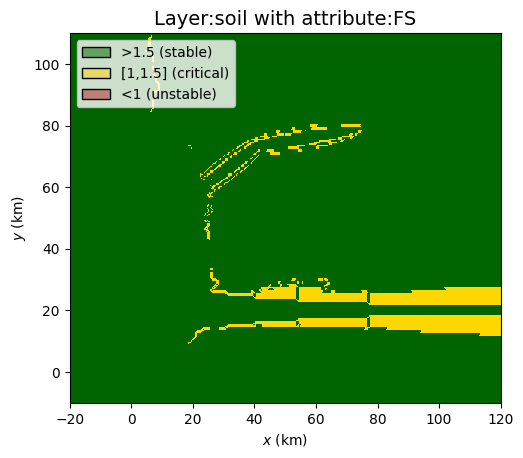

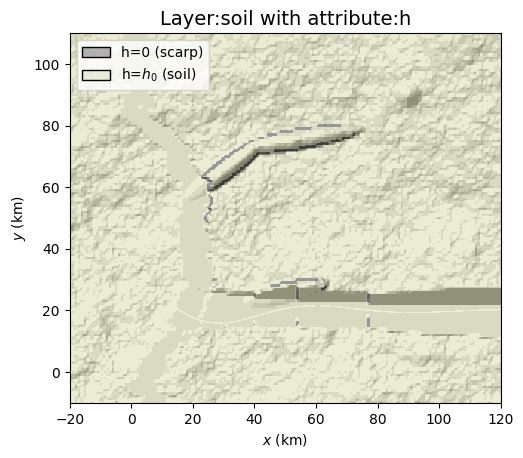

In [8]:
GenMR_env.plot_EnvLayer_attr(topoLayer, 'aspect', file_ext = 'jpg')
GenMR_env.plot_EnvLayer_attr(soilLayer, 'FS')
GenMR_env.plot_EnvLayer_attr(soilLayer, 'h', hillshading_z = topoLayer.z)

### 1.5. A note on environmental layer downscaling

Different environmental processes may occur at different scales. The default resolution is defined by the pixel width `gridPar['w']`, which represents the finest one possible for environmental layers. A grid class instance can be downscaled with the function `downscale_RasterGrid()`. This was for example used to generate the topography (in `EnvLayer_topo()`). Another process defined at lower resolution will be the road network in Section 2 which will required downscaled terrain slope and water mask as inputs. Different pooling methods (min, mean or max) are available in function `pooling()`. This is illustrated below with the resolution reduced by a factor `f = 50` to emphasize the impact on the layers.

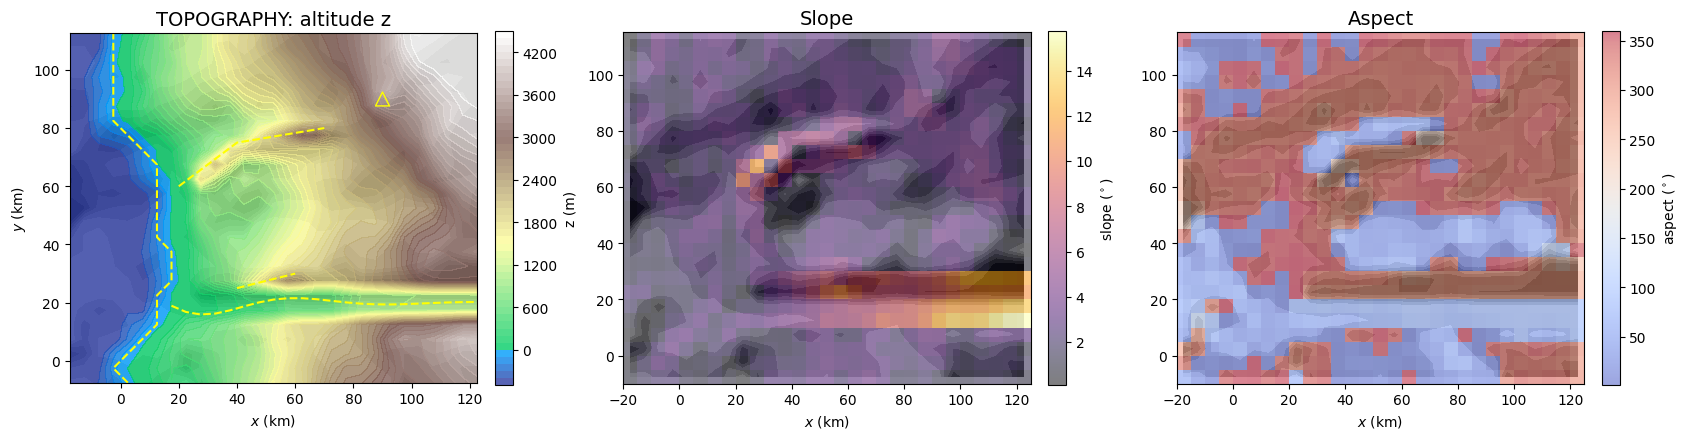

In [9]:
f = 50
grid_downscaled = GenMR_env.downscale_RasterGrid(grid, f, appl = 'pooling')
topoLayer_downscaled = copy.deepcopy(topoLayer)
topoLayer_downscaled.grid = grid_downscaled
topoLayer_downscaled.z = GenMR_utils.pooling(topoLayer.z, f, method = 'mean')             # mean-pooling example

GenMR_env.plot_EnvLayers([topoLayer_downscaled])    # notice that properties are automatically recomputed

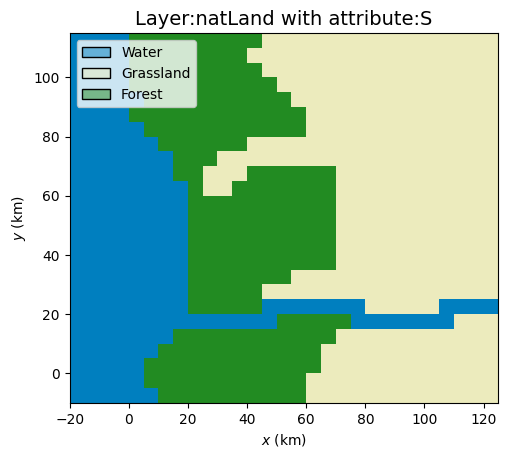

In [10]:
natLandLayer_downscaled = copy.deepcopy(natLandLayer)
natLandLayer_downscaled.grid = grid_downscaled
natLandLayer_downscaled.S = GenMR_utils.pooling(natLandLayer.S, f, method = 'min')        # min-pooling example

GenMR_env.plot_EnvLayer_attr(natLandLayer_downscaled, 'S')

## 2. Technological environment generation

The technological system refers to all things produced by humans. This includes the built environment and critical infrastructures (transportation network, energy production and distribution). Goods and services (via businesses) will be defined in the socio-economic system.

TO DEVELOP...